## 1. Configuración e Importaciones

In [1]:
# Librerías estándar
import sys
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, accuracy_score, precision_recall_fscore_support
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
%matplotlib inline

# Agregar src al path
sys.path.insert(0, os.path.abspath('../src'))

# Semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Configuración completada")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Configuración completada
PyTorch version: 2.9.1+cpu
Device: CPU


## 2. Información del Modelo Pre-entrenado

Cargamos la información del modelo previamente entrenado.

In [2]:
# Cargar información del modelo
model_dir = Path('../models/best')

with open(model_dir / 'MODEL_INFO.json', 'r') as f:
    model_info = json.load(f)

with open(model_dir / 'complete_metrics.json', 'r') as f:
    complete_metrics = json.load(f)

with open(model_dir / 'run_meta.json', 'r') as f:
    run_meta = json.load(f)

print("="*70)
print("INFORMACIÓN DEL MODELO")
print("="*70)
print(f"Nombre: {model_info['nombre']}")
print(f"Arquitectura: {model_info['arquitectura']}")
print(f"Framework: {model_info['framework']}")
print(f"Parámetros totales: {model_info['parametros_totales']:,}")
print(f"Mejor época: {model_info['mejor_epoch']}")
print(f"\nMétricas del modelo:")
print(f"  - Accuracy: {model_info['metricas']['accuracy']:.4f} ({model_info['metricas']['accuracy']*100:.2f}%)")
print(f"  - F1-Score (Macro): {model_info['metricas']['f1_score_macro']:.4f} ({model_info['metricas']['f1_score_macro']*100:.2f}%)")
print(f"  - F1-Score (Micro): {model_info['metricas']['f1_score_micro']:.4f} ({model_info['metricas']['f1_score_micro']*100:.2f}%)")
print(f"\nDescripción:\n{model_info['descripcion']}")
print("="*70)

INFORMACIÓN DEL MODELO
Nombre: BiGRU + Attention - Bulgarian Squat Classifier
Arquitectura: BiGRUClassifierImproved
Framework: PyTorch
Parámetros totales: 292,041
Mejor época: 9

Métricas del modelo:
  - Accuracy: 0.6574 (65.74%)
  - F1-Score (Macro): 0.5198 (51.98%)
  - F1-Score (Micro): 0.5838 (58.38%)

Descripción:
Modelo BiGRU con mecanismo de atenciÃ³n para clasificaciÃ³n de ejercicios Bulgarian Split Squat. Clasifica entre ejecuciÃ³n correcta y 3 tipos de errores comunes.


## 3. Configuración del Entrenamiento Utilizada

In [3]:
config = complete_metrics['config']

print("="*70)
print("CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)
print(f"Entrada: {config['in_dim']} features (33 landmarks × 2 coordenadas)")
print(f"Capas ocultas: {config['hidden_sizes']}")
print(f"Clases: {config['num_classes']}")
print(f"Dropout: {config['dropout']}")
print(f"Atención: {config['attention']}")
print(f"\nHiperparámetros:")
print(f"  - Batch size: {config['batch_size']}")
print(f"  - Learning rate: {config['lr']}")
print(f"  - Épocas: {config['epochs']}")
print(f"  - Patience: {config['patience']}")
print(f"  - Device: {config['device']}")
print("="*70)

CONFIGURACIÓN DE ENTRENAMIENTO
Entrada: 66 features (33 landmarks × 2 coordenadas)
Capas ocultas: [128, 64]
Clases: 4
Dropout: 0.3
Atención: True

Hiperparámetros:
  - Batch size: 32
  - Learning rate: 0.001
  - Épocas: 50
  - Patience: 20
  - Device: cpu


## 4. Carga del Dataset

Cargamos el mismo dataset utilizado para entrenar el modelo.

Dataset cargado: ../data/raw/landmarks_dataset_BALANCEADO_v2.csv
Dimensiones: (16501, 104)

Columnas: ['video_id', 'frame_number', 'augmentation_type', 'frame_name', '0_x', '0_y', '0_z', '1_x', '1_y', '1_z']...

Distribución de clases:
prediccion
0    8501
1    8000
Name: count, dtype: int64


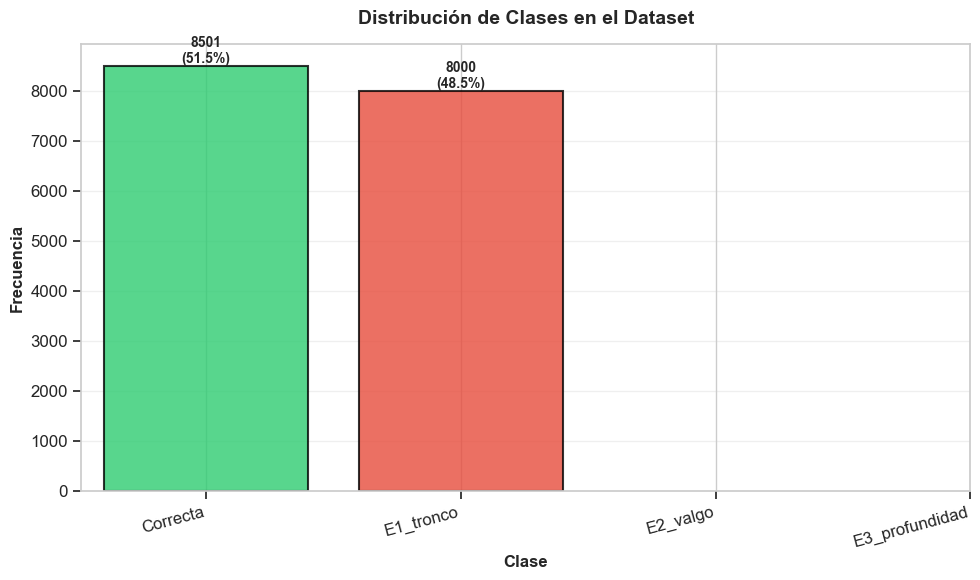


Total de muestras: 16,501


In [4]:
# Cargar dataset
dataset_path = '../data/raw/landmarks_dataset_BALANCEADO_v2.csv'
df = pd.read_csv(dataset_path)

print(f"Dataset cargado: {dataset_path}")
print(f"Dimensiones: {df.shape}")
print(f"\nColumnas: {list(df.columns[:10])}...")
print(f"\nDistribución de clases:")
print(df['prediccion'].value_counts().sort_index())

# Visualizar distribución
fig, ax = plt.subplots(figsize=(10, 6))
class_names = ['Correcta', 'E1_tronco', 'E2_valgo', 'E3_profundidad']
counts = df['prediccion'].value_counts().sort_index()
bars = ax.bar(range(len(counts)), counts.values, color=['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'], 
              alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Clases en el Dataset', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}\n({count/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/figures/dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal de muestras: {len(df):,}")

## 5. Preparación de Datos para Evaluación

Replicamos el mismo proceso de división del dataset.

Features extraídas: (16501, 66)
Labels: (16501,)
Videos únicos: 13

División del dataset:
  Train: 6550 muestras (39.7%)
  Val:   7771 muestras (47.1%)
  Test:  2180 muestras (13.2%)

División del dataset:
  Train: 6550 muestras (39.7%)
  Val:   7771 muestras (47.1%)
  Test:  2180 muestras (13.2%)


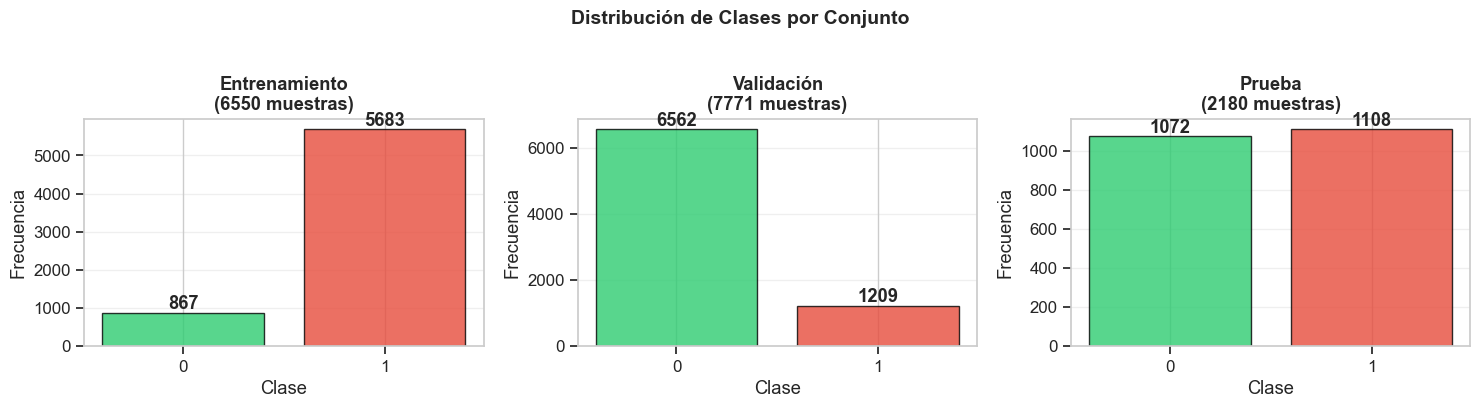

In [5]:
# Extraer features y labels
feature_cols = [col for col in df.columns if col.endswith(('_x', '_y')) and col[0].isdigit()]
feature_cols = sorted(feature_cols, key=lambda x: (int(x.split('_')[0]), x.split('_')[1]))

X = df[feature_cols].values
y = df['prediccion'].values
video_ids = df['video_id'].values

print(f"Features extraídas: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Videos únicos: {len(np.unique(video_ids))}")

# División estratificada por video (misma configuración que el entrenamiento)
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.70, random_state=SEED)
train_idx, temp_idx = next(gss1.split(X, y, groups=video_ids))

X_train, X_temp = X[train_idx], X[temp_idx]
y_train, y_temp = y[train_idx], y[temp_idx]
video_ids_temp = video_ids[temp_idx]

gss2 = GroupShuffleSplit(n_splits=1, train_size=0.50, random_state=SEED)
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=video_ids_temp))

X_val, X_test = X_temp[val_idx], X_temp[test_idx]
y_val, y_test = y_temp[val_idx], y_temp[test_idx]

# Reshape para el modelo
X_train = X_train.reshape(-1, 1, X_train.shape[-1])
X_val = X_val.reshape(-1, 1, X_val.shape[-1])
X_test = X_test.reshape(-1, 1, X_test.shape[-1])

print(f"\nDivisión del dataset:")
print(f"  Train: {X_train.shape[0]} muestras ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} muestras ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} muestras ({X_test.shape[0]/len(df)*100:.1f}%)")

# Visualizar distribución por conjunto
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

for ax, (data, title) in zip(axes, [(y_train, 'Entrenamiento'), (y_val, 'Validación'), (y_test, 'Prueba')]):
    unique, counts = np.unique(data, return_counts=True)
    bars = ax.bar(unique, counts, color=[colors[i] for i in unique], alpha=0.8, edgecolor='black')
    ax.set_title(f'{title}\n({len(data)} muestras)', fontweight='bold')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')
    ax.set_xticks(unique)
    ax.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribución de Clases por Conjunto', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/data_splits.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Carga del Modelo Pre-entrenado

In [7]:
from bulgarian_squat.model_improved import BiGRUClassifierImproved

# Configuración del modelo (de run_meta.json)
model_config = {
    'in_dim': run_meta['in_dim'],
    'hidden1': run_meta['hidden_dim1'],
    'hidden2': run_meta['hidden_dim2'],
    'num_classes': run_meta['num_classes'],
    'dropout': run_meta['dropout'],
    'use_attention': run_meta['use_attention'],
    'use_batch_norm': run_meta['use_batch_norm']
}

# Crear modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiGRUClassifierImproved(**model_config).to(device)

# Cargar pesos pre-entrenados
# El checkpoint contiene directamente los pesos del modelo (state_dict)
checkpoint = torch.load(model_dir / 'best_model_bigru.pt', map_location=device)
model.load_state_dict(checkpoint)
model.eval()

print("="*70)
print("MODELO CARGADO EXITOSAMENTE")
print("="*70)
print(f"Arquitectura: {model.__class__.__name__}")
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device: {device}")
print(f"\nModelo pre-entrenado cargado desde: best_model_bigru.pt")
print(f"Mejor época registrada (MODEL_INFO): {model_info['mejor_epoch']}")
print(f"F1-Score en test (MODEL_INFO): {model_info['metricas']['f1_score_macro']:.4f}")
print("="*70)

MODELO CARGADO EXITOSAMENTE
Arquitectura: BiGRUClassifierImproved
Parámetros totales: 292,041
Device: cpu

Modelo pre-entrenado cargado desde: best_model_bigru.pt
Mejor época registrada (MODEL_INFO): 9
F1-Score en test (MODEL_INFO): 0.5198


## 7. Historial de Entrenamiento

Visualizamos las curvas de aprendizaje del modelo durante el entrenamiento.

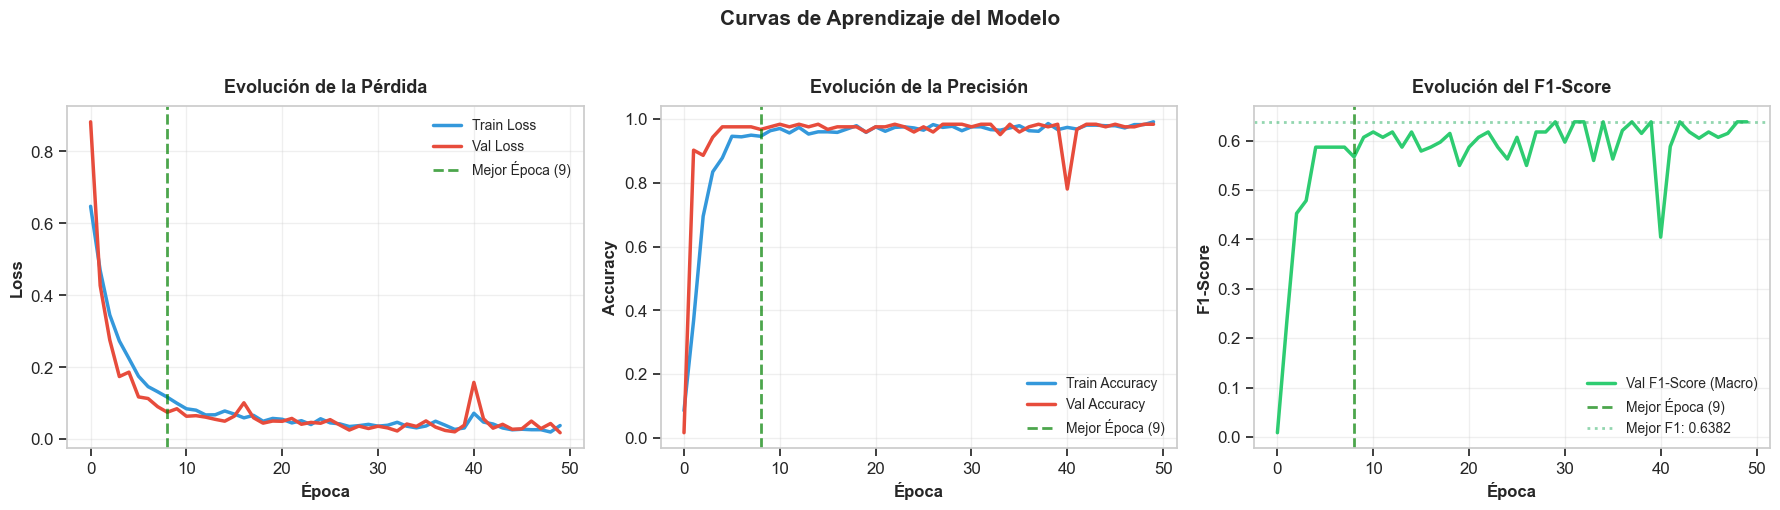

Épocas entrenadas: 50
Mejor época: 9
Mejor F1-Score en validación: 0.6382


In [8]:
history = complete_metrics['training_history']
best_epoch = model_info['mejor_epoch'] - 1  # Convertir a índice 0-based

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pérdida
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2.5, color='#3498db')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2.5, color='#e74c3c')
axes[0].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2, 
                label=f'Mejor Época ({best_epoch+1})')
axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Evolución de la Pérdida', fontsize=13, fontweight='bold', pad=10)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[1].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2,
                label=f'Mejor Época ({best_epoch+1})')
axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Evolución de la Precisión', fontsize=13, fontweight='bold', pad=10)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# F1-Score
best_val_f1 = max(history['val_f1'])
axes[2].plot(history['val_f1'], label='Val F1-Score (Macro)', linewidth=2.5, color='#2ecc71')
axes[2].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2,
                label=f'Mejor Época ({best_epoch+1})')
axes[2].axhline(y=best_val_f1, color='#27ae60', linestyle=':', alpha=0.5, linewidth=2,
                label=f'Mejor F1: {best_val_f1:.4f}')
axes[2].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('Evolución del F1-Score', fontsize=13, fontweight='bold', pad=10)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Curvas de Aprendizaje del Modelo', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Épocas entrenadas: {len(history['train_loss'])}")
print(f"Mejor época: {best_epoch + 1}")
print(f"Mejor F1-Score en validación: {best_val_f1:.4f}")

## 8. Evaluación en Conjunto de Prueba

Evaluamos el modelo en el conjunto de prueba para obtener las métricas finales.

In [9]:
# Crear DataLoader para test
test_dataset = TensorDataset(
    torch.FloatTensor(X_test),
    torch.LongTensor(y_test)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluar modelo
test_predictions = []
test_targets = []
test_probs = []

model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        mask = torch.ones(batch_X.size(0), batch_X.size(1), device=device)
        
        outputs = model(batch_X, mask)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_targets.extend(batch_y.numpy())
        test_probs.extend(probs.cpu().numpy())

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_probs = np.array(test_probs)

# Calcular métricas
test_acc = accuracy_score(test_targets, test_predictions)
test_f1_macro = f1_score(test_targets, test_predictions, average='macro')
test_f1_micro = f1_score(test_targets, test_predictions, average='micro')

print("="*70)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*70)
print(f"Muestras evaluadas: {len(test_targets)}")
print(f"\nMétricas Globales:")
print(f"  Accuracy:        {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  F1-Score Macro:  {test_f1_macro:.4f} ({test_f1_macro*100:.2f}%)")
print(f"  F1-Score Micro:  {test_f1_micro:.4f} ({test_f1_micro*100:.2f}%)")
print("="*70)

EVALUACIÓN EN CONJUNTO DE PRUEBA
Muestras evaluadas: 2180

Métricas Globales:
  Accuracy:        0.5083 (50.83%)
  F1-Score Macro:  0.3378 (33.78%)
  F1-Score Micro:  0.5083 (50.83%)


## 9. Reporte Detallado por Clase

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

    correcta     0.5000    0.0009    0.0019      1072
   E1_tronco     0.5083    0.9991    0.6738      1108

    accuracy                         0.5083      2180
   macro avg     0.5041    0.5000    0.3378      2180
weighted avg     0.5042    0.5083    0.3434      2180


TABLA DE MÉTRICAS POR CLASE


,Clase,Precision,Recall,F1-Score,Soporte
0,correcta,0.5000,0.0009,0.0019,1072
1,E1_tronco,0.5083,0.9991,0.6738,1108


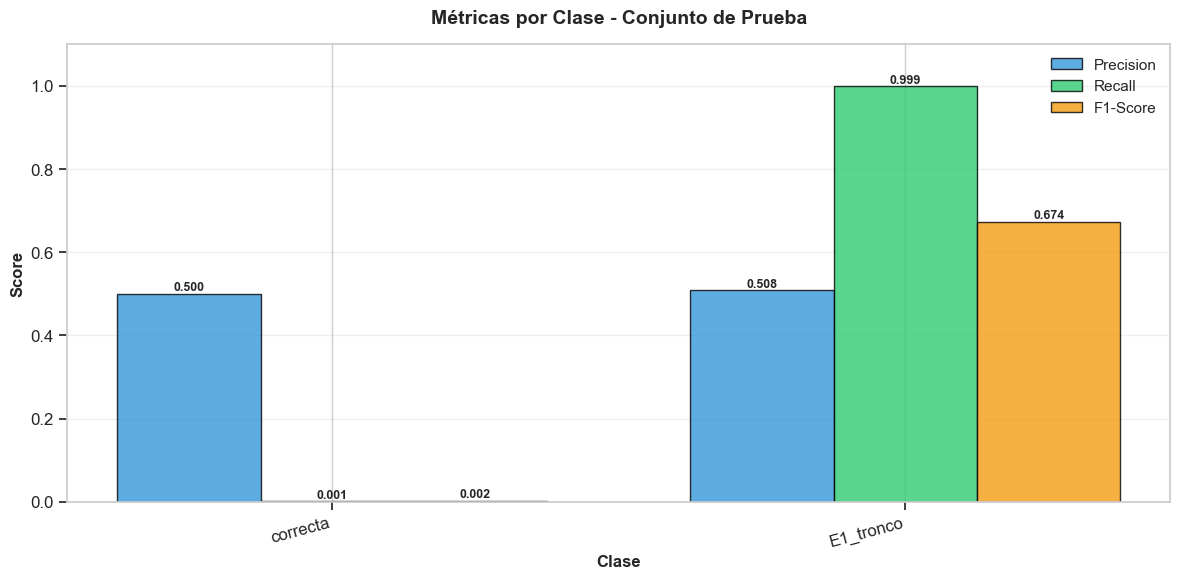

In [10]:
class_names_list = ['correcta', 'E1_tronco', 'E2_valgo', 'E3_profundidad']

# Determinar clases presentes
unique_classes = np.unique(np.concatenate([test_targets, test_predictions]))
target_names_present = [class_names_list[i] for i in unique_classes]

# Reporte de clasificación
report = classification_report(
    test_targets, test_predictions,
    labels=unique_classes,
    target_names=target_names_present,
    digits=4
)

print("="*70)
print("REPORTE DE CLASIFICACIÓN")
print("="*70)
print(report)

# Métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(
    test_targets, test_predictions, labels=unique_classes
)

df_metrics = pd.DataFrame({
    'Clase': target_names_present,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Soporte': support
})

print("\n" + "="*70)
print("TABLA DE MÉTRICAS POR CLASE")
print("="*70)
display(df_metrics.style.format({
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['Precision', 'Recall', 'F1-Score']))

# Visualización de métricas por clase
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(target_names_present))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#f39c12', alpha=0.8, edgecolor='black')

ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métricas por Clase - Conjunto de Prueba', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(target_names_present, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Añadir valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/figures/metrics_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Matriz de Confusión

Analizamos los patrones de confusión entre clases.

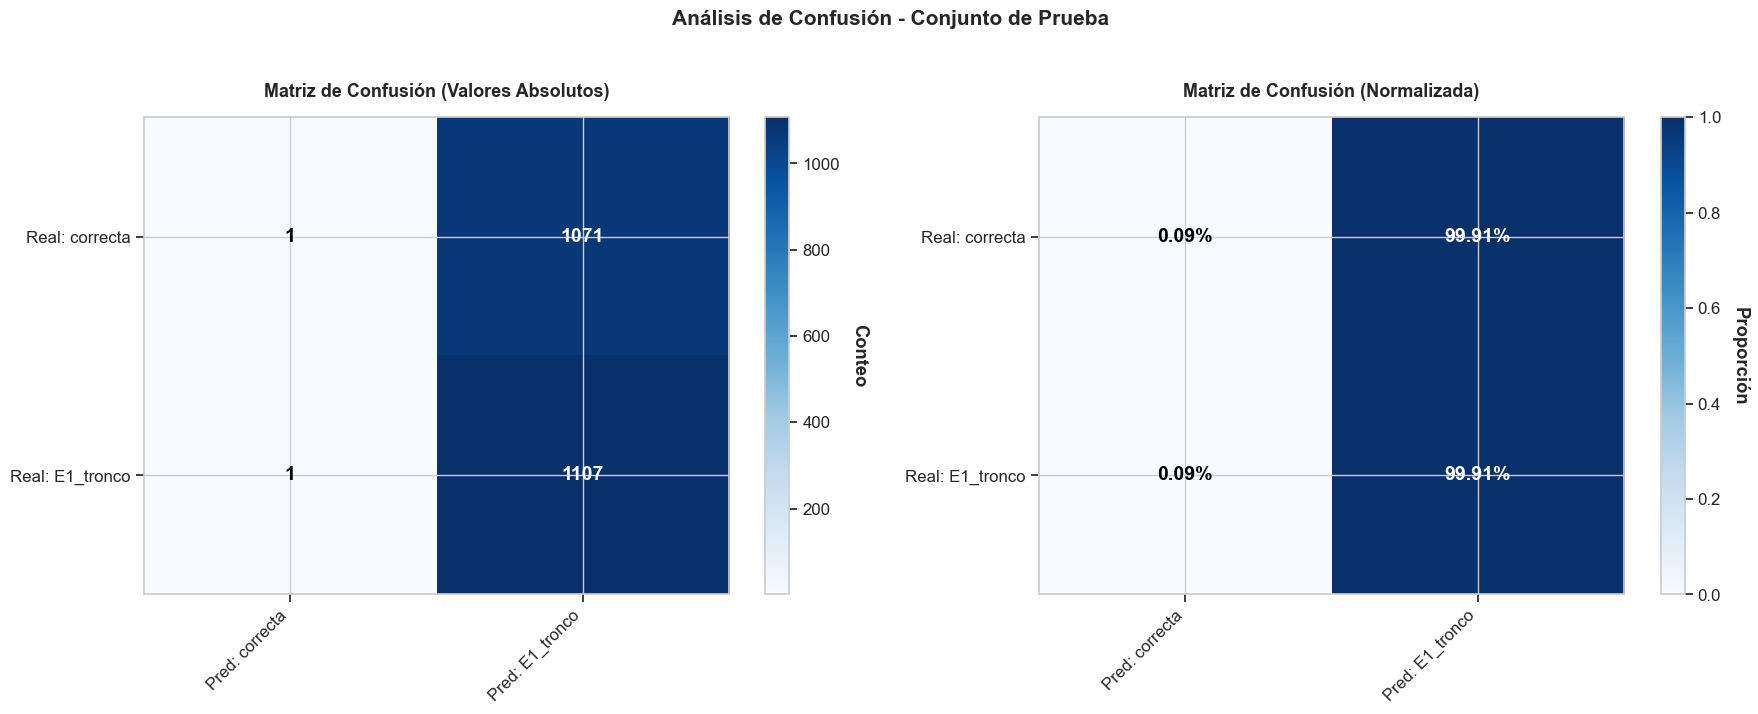


ANÁLISIS DE ERRORES POR CLASE

CORRECTA:
  Tasa de acierto: 0.09%
  Predicciones correctas: 1 / 1072
  Principal confusión: E1_tronco (99.91%, 1071 casos)

E1_TRONCO:
  Tasa de acierto: 99.91%
  Predicciones correctas: 1107 / 1108


In [11]:
# Calcular matriz de confusión
cm = confusion_matrix(test_targets, test_predictions, labels=unique_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Matriz absoluta
im1 = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_xticks(range(len(target_names_present)))
axes[0].set_yticks(range(len(target_names_present)))
axes[0].set_xticklabels([f'Pred: {name}' for name in target_names_present], rotation=45, ha='right')
axes[0].set_yticklabels([f'Real: {name}' for name in target_names_present])

for i in range(len(target_names_present)):
    for j in range(len(target_names_present)):
        text = axes[0].text(j, i, f'{cm[i, j]}',
                           ha="center", va="center",
                           color="white" if cm[i, j] > cm.max()/2 else "black",
                           fontsize=14, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Conteo', rotation=270, labelpad=20, fontweight='bold')
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=13, fontweight='bold', pad=15)

# Matriz normalizada
im2 = axes[1].imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[1].set_xticks(range(len(target_names_present)))
axes[1].set_yticks(range(len(target_names_present)))
axes[1].set_xticklabels([f'Pred: {name}' for name in target_names_present], rotation=45, ha='right')
axes[1].set_yticklabels([f'Real: {name}' for name in target_names_present])

for i in range(len(target_names_present)):
    for j in range(len(target_names_present)):
        text = axes[1].text(j, i, f'{cm_normalized[i, j]:.2%}',
                           ha="center", va="center",
                           color="white" if cm_normalized[i, j] > 0.5 else "black",
                           fontsize=14, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Proporción', rotation=270, labelpad=20, fontweight='bold')
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=13, fontweight='bold', pad=15)

plt.suptitle('Análisis de Confusión - Conjunto de Prueba', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis de errores
print("\n" + "="*70)
print("ANÁLISIS DE ERRORES POR CLASE")
print("="*70)
for i, clase in enumerate(target_names_present):
    accuracy_clase = cm_normalized[i, i]
    print(f"\n{clase.upper()}:")
    print(f"  Tasa de acierto: {accuracy_clase:.2%}")
    print(f"  Predicciones correctas: {cm[i, i]} / {cm[i].sum()}")
    
    errores = [(j, cm_normalized[i, j], cm[i, j]) for j in range(len(target_names_present)) if j != i]
    errores_sorted = sorted(errores, key=lambda x: x[1], reverse=True)
    
    if len(errores_sorted) > 0 and errores_sorted[0][1] > 0.05:
        print(f"  Principal confusión: {target_names_present[errores_sorted[0][0]]} "
              f"({errores_sorted[0][1]:.2%}, {errores_sorted[0][2]} casos)")
print("="*70)

## 11. Guardar Resultados Finales

In [12]:
# Crear directorio de resultados
results_dir = Path('../results/final_evaluation')
results_dir.mkdir(exist_ok=True, parents=True)

# Guardar métricas de evaluación
evaluation_results = {
    'model_info': model_info,
    'test_metrics': {
        'accuracy': float(test_acc),
        'f1_score_macro': float(test_f1_macro),
        'f1_score_micro': float(test_f1_micro),
        'num_samples': int(len(test_targets))
    },
    'per_class_metrics': {
        'classes': target_names_present,
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1.tolist(),
        'support': support.tolist()
    },
    'confusion_matrix': {
        'absolute': cm.tolist(),
        'normalized': cm_normalized.tolist()
    },
    'data_split': {
        'train_samples': int(len(y_train)),
        'val_samples': int(len(y_val)),
        'test_samples': int(len(y_test)),
        'total_samples': int(len(df))
    }
}

with open(results_dir / 'evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(evaluation_results, f, indent=2, ensure_ascii=False)

# Guardar predicciones
predictions_df = pd.DataFrame({
    'true_label': test_targets,
    'predicted_label': test_predictions,
    'correct': test_targets == test_predictions,
    'prob_class_0': test_probs[:, 0],
    'prob_class_1': test_probs[:, 1] if test_probs.shape[1] > 1 else 0,
    'prob_class_2': test_probs[:, 2] if test_probs.shape[1] > 2 else 0,
    'prob_class_3': test_probs[:, 3] if test_probs.shape[1] > 3 else 0
})
predictions_df.to_csv(results_dir / 'test_predictions.csv', index=False)

print("="*70)
print("RESULTADOS GUARDADOS")
print("="*70)
print(f"Directorio: {results_dir}")
print(f"Archivos generados:")
print(f"  - evaluation_results.json")
print(f"  - test_predictions.csv")
print("="*70)

RESULTADOS GUARDADOS
Directorio: ..\results\final_evaluation
Archivos generados:
  - evaluation_results.json
  - test_predictions.csv


## 12. Resumen Final del Proyecto

In [ ]:
print("="*70)
print("RESUMEN FINAL DEL PROYECTO")
print("="*70)

print(f"\n1. DATOS")
print(f"   Dataset: landmarks_dataset_BALANCEADO_v2.csv")
print(f"   Total de muestras: {len(df):,}")
print(f"   Features: {X.shape[1]} (33 landmarks × 2 coordenadas)")
print(f"   Clases: {len(class_names_list)}")
print(f"   División: 70% train, 15% val, 15% test (por video)")

print(f"\n2. MODELO")
print(f"   Arquitectura: {model_info['arquitectura']}")
print(f"   Framework: {model_info['framework']}")
print(f"   Parámetros: {model_info['parametros_totales']:,}")
print(f"   Capas ocultas: [{run_meta['hidden_dim1']}, {run_meta['hidden_dim2']}]")
print(f"   Características: Attention + BatchNorm + Dropout({run_meta['dropout']})")

print(f"\n3. ENTRENAMIENTO")
print(f"   Épocas entrenadas: {len(history['train_loss'])}")
print(f"   Mejor época: {model_info['mejor_epoch']}")
print(f"   Mejor F1 en validación: {best_val_f1:.4f}")
print(f"   Optimizador: Adam (lr={config['lr']})")
print(f"   Batch size: {config['batch_size']}")

print(f"\n4. RESULTADOS EN TEST")
print(f"   Muestras evaluadas: {len(test_targets)}")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   F1-Macro:  {test_f1_macro:.4f} ({test_f1_macro*100:.2f}%)")
print(f"   F1-Micro:  {test_f1_micro:.4f} ({test_f1_micro*100:.2f}%)")

print(f"\n5. RENDIMIENTO POR CLASE")
for i, clase in enumerate(target_names_present):
    print(f"   {clase:20s}: F1={f1[i]:.4f}, Precision={precision[i]:.4f}, Recall={recall[i]:.4f}")

print(f"\n6. INTERPRETACIÓN")
if len(f1) > 0:
    best_class = target_names_present[np.argmax(f1)]
    worst_class = target_names_present[np.argmin(f1)]
    print(f"   Mejor clase detectada: {best_class} (F1={max(f1):.4f})")
    print(f"   Clase más difícil: {worst_class} (F1={min(f1):.4f})")
    print(f"   Rendimiento general: {'EXCELENTE' if test_f1_macro > 0.7 else 'BUENO' if test_f1_macro > 0.5 else 'MODERADO'}")

print(f"\n7. ARCHIVOS GENERADOS")
print(f"   Figuras: docs/figures/")
print(f"     - dataset_distribution.png")
print(f"     - data_splits.png")
print(f"     - training_curves.png")
print(f"     - metrics_by_class.png")
print(f"     - confusion_matrix.png")
print(f"   Resultados: results/final_evaluation/")
print(f"     - evaluation_results.json")
print(f"     - test_predictions.csv")

print("\n" + "="*70)
print("PROYECTO COMPLETADO - RESULTADOS REPRODUCIBLES")
print("="*70)

RESUMEN FINAL DEL PROYECTO

1. DATOS
   Dataset: landmarks_dataset_BALANCEADO_v2.csv
   Total de muestras: 16,501
   Features: 66 (33 landmarks × 2 coordenadas)
   Clases: 4
   División: 70% train, 15% val, 15% test (por video)

2. MODELO
   Arquitectura: BiGRUClassifierImproved
   Framework: PyTorch
   Parámetros: 292,041
   Capas ocultas: [128, 64]
   Características: Attention + BatchNorm + Dropout(0.3)

3. ENTRENAMIENTO
   Épocas entrenadas: 50


KeyError: 'mejor_epoca'